# Homework 1

# A fashionable use case : clothing classification with `fashion-mnist`

- Load data with `fashion_mnist.load_data()` 
- There is no validation set, only a train and test set. 
- The labels correspond to the following things

| Label number | Label name  |
|--------------|-------------|
| 0	           | T-shirt/top |
| 1	           | Trouser     |
| 2	           | Pullover    |
| 3	           | Dress       |
| 4	           | Coat        |
| 5	           | Sandal      |
| 6	           | Shirt       |
| 7	           | Sneaker     |
| 8	           | Bag         |
| 9	           | Ankle boot  |

## Your job

- Try to understand the data, visualize it, like we did before with MNIST and noMNIST
- Create a neural network, using the ideas from before, that classify accurately the clothes on the test set
- You will need to build a validation set from the train set in order to tune hyperparameters

## We want to see the following things

- Some learning curves (training) and the accuracy obtained on the test set for the architecture you considered
- A discussion about the impact of the hyperparameters on the accuracy (size of the kernels, number of kernels, number of layers, etc.) 
- A clear comparison between your solutions (a table, or plots comparing the results obtained with different hyper-parameters and different architectures)
- An explanation of what kind of clothes are hard to distinguish and why (some visual explanation)
- You'll get a good grade if you reach a good accuracy **and** if your notebook is clean, with clear graphs and explanations of what you did **and** if you did serious comparisons between different architectures
- You can do everything on your laptop, but it might be a good idea to use google `colab` (https://colab.research.google.com/) to get free access to a GPU
- You will send your notebook **containing** the results (**WE WON'T RUN YOUR NOTEBOOK**), namely with the graphs and results that you want to show, as a **unique** jupyter notebook file (`.ipynb` extension). We won't open any other supplementary file.

## Send your work using the following google form :

- https://forms.gle/G3Rwfcuj3MZfgXhr8

(you will need to create a google account if you don't have one).

## Example of architecture

As a start, you can use the following architecture (but you can and will change it) :

- Convolutional layer with 64 filters and 5 * 5 kernel sizes and 'relu' activation
- Max pooling with pool size 2 * 2
- Dropout with probability 0.25

- Convolutional layer with 128 filters and 5 * 5 kernel sizes and 'relu' activation
- Max pooling with pool size 2 * 2
- Dropout with probability 0.25

- Convolutional layer with 256 filters and 3 * 3 kernel sizes and 'relu' activation
- Max pooling with pool size 2 * 2
- Dropout with probability 0.25

- Dense layer with 256 units
- Dropout with probability 0.5
- Dense output layer with softmax activation

In [281]:
#importing libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.preprocessing import image
from keras.optimizers import SGD

# Plotly
import plotly
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots


import json

In [114]:
# Loading of fashion_mnist dataset, creation of list for dataset string labels
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt',
               'Sneaker', 'Bag', 'Ankle boot']

### The MNIST Fashion dataset contains 70,000 images. 60,000 are used in the training set and 10,000 in the testing set. 

In [115]:
# Analysis of shape of datasets
print('Train set: X = %s, y = %s' % (train_images.shape, train_labels.shape))
print("\n")
print('Test set: X = %s, y = %s' % (test_images.shape, test_labels.shape))

Train set: X = (60000, 28, 28), y = (60000,)


Test set: X = (10000, 28, 28), y = (10000,)


### By displaying one example of the train images, we see that the pixel values range from 0 to 255. Before we can start training any model we need to normalize the pixel values to a range of 0 to 1

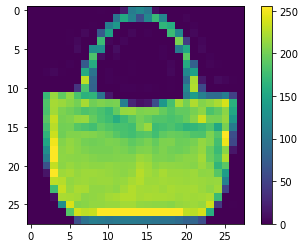

Label for training example # 100: Bag


In [116]:
selected_ex = 100
plt.figure()
plt.imshow(train_images[selected_ex])
plt.colorbar()
plt.grid(False)
plt.show()
#This is a bag so should be type 8
print("Label for training example # %i: %s" %(selected_ex, class_names[train_labels[selected_ex]]))

In [117]:
# Normalization of pixel values of images from 0-255 to 0-1

def pixel_normalization(train, test):
    # Convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # Normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # Return normalized images
    return train_norm, test_norm

train_images, test_images = pixel_normalization(train_images, test_images)

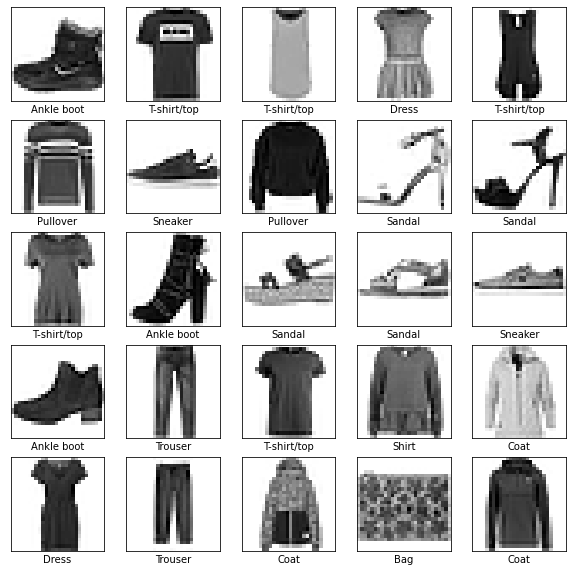

In [118]:
# Display of first 25 items in the dataset

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [119]:
# Reshaping of dataset to use only one color channel and be able to train a model

def dataset_reshape(trainX, trainY, testX, testY):
    # reshape dataset to have a single color channel as they are greyscale
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    
    # one hot encode target values for labelling
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY

train_images, train_labels, test_images, test_labels = dataset_reshape(train_images, 
                                                                       train_labels, 
                                                                       test_images,
                                                                       test_labels) 


# CNN Architectures

In [8]:
#defining the model

def define_model_gaiffas():
    model = Sequential()
    # Convolutional layer with 64 filters and 5 * 5 kernel sizes and 'relu' activation
    model.add(Conv2D(64, (5, 5), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    
    # Max pooling with pool size 2 * 2
    model.add(MaxPooling2D((2, 2)))
    
    # Dropout with probability 0.25
    model.add(Dropout(0.25))
    
    # Convolutional layer with 128 filters and 5 * 5 kernel sizes and 'relu' activation
    model.add(Conv2D(128, (5, 5), activation='relu', kernel_initializer='he_uniform'))
    
    # Max pooling with pool size 2 * 2
    model.add(MaxPooling2D((2, 2)))
    
    # Dropout with probability 0.25
    model.add(Dropout(0.25))
    
    # Convolutional layer with 256 filters and 3 * 3 kernel sizes and 'relu' activation
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    
    # Max pooling with pool size 2 * 2
    model.add(MaxPooling2D((2, 2)))
    
    # Dropout with probability 0.25
    model.add(Dropout(0.25))
    
    # Dense layer with 256 units
    model.add(Dense(256))
    
    # Dropout with probability 0.25
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    # Dense output layer with softmax activation
    model.add(Dense(10, activation='softmax'))
    
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# define cnn model
def define_model_web():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def define_model_alex():
    model = Sequential()
    model.add(Conv2D(64, (5, 5), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def define_model_alex2():
    model = Sequential()
    model.add(Conv2D(64, (5, 5), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dropout(0.25))
    model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [213]:
gaiffas_model = define_model_gaiffas()
alex_model = define_model_alex()
alex_model2 = define_model_alex2()
web_model = define_model_web()

In [214]:
gaiffas_model.fit(train_images, train_labels, 
                  batch_size=32, epochs=15, 
                  validation_split=0.2, shuffle=True)

Epoch 1/15
1500/1500 [==============================] - 22s 15ms/step - loss: 0.6241 - accuracy: 0.7714 - val_loss: 0.4002 - val_accuracy: 0.8545
Epoch 2/15
1500/1500 [==============================] - 22s 15ms/step - loss: 0.4391 - accuracy: 0.8385 - val_loss: 0.3957 - val_accuracy: 0.8559
Epoch 3/15
1500/1500 [==============================] - 22s 14ms/step - loss: 0.3934 - accuracy: 0.8554 - val_loss: 0.3262 - val_accuracy: 0.8808
Epoch 4/15
1500/1500 [==============================] - 21s 14ms/step - loss: 0.3705 - accuracy: 0.8639 - val_loss: 0.3217 - val_accuracy: 0.8793
Epoch 5/15
1500/1500 [==============================] - 22s 15ms/step - loss: 0.3497 - accuracy: 0.8700 - val_loss: 0.3049 - val_accuracy: 0.8881
Epoch 6/15
1500/1500 [==============================] - 22s 15ms/step - loss: 0.3384 - accuracy: 0.8745 - val_loss: 0.3000 - val_accuracy: 0.8886
Epoch 7/15
1500/1500 [==============================] - 22s 15ms/step - loss: 0.3217 - accuracy: 0.8801 - val_loss: 0.2828 -

In [218]:
alex_model.fit(train_images, train_labels, 
               batch_size=32, epochs=15, 
               validation_split=0.2, shuffle=True)

Epoch 1/15
1500/1500 [==============================] - 7s 4ms/step - loss: 0.4755 - accuracy: 0.8490 - val_loss: 0.3285 - val_accuracy: 0.8848
Epoch 2/15
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3072 - accuracy: 0.8905 - val_loss: 0.3146 - val_accuracy: 0.8890
Epoch 3/15
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2718 - accuracy: 0.9036 - val_loss: 0.2966 - val_accuracy: 0.8948
Epoch 4/15
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2492 - accuracy: 0.9128 - val_loss: 0.2760 - val_accuracy: 0.9005
Epoch 5/15
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2324 - accuracy: 0.9180 - val_loss: 0.2803 - val_accuracy: 0.8997
Epoch 6/15
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2192 - accuracy: 0.9226 - val_loss: 0.2721 - val_accuracy: 0.9033
Epoch 7/15
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2064 - accuracy: 0.9260 - val_loss: 0.2714 - val_accuracy:

In [252]:
alex_model2.fit(train_images, train_labels, batch_size=32, epochs=15, validation_split=0.2, shuffle=True)

Epoch 1/15
1500/1500 [==============================] - 17s 11ms/step - loss: 0.5954 - accuracy: 0.7850 - val_loss: 0.3610 - val_accuracy: 0.8672
Epoch 2/15
1500/1500 [==============================] - 17s 11ms/step - loss: 0.4054 - accuracy: 0.8548 - val_loss: 0.3182 - val_accuracy: 0.8816
Epoch 3/15
1500/1500 [==============================] - 17s 11ms/step - loss: 0.3597 - accuracy: 0.8674 - val_loss: 0.3041 - val_accuracy: 0.8856
Epoch 4/15
1500/1500 [==============================] - 17s 11ms/step - loss: 0.3266 - accuracy: 0.8794 - val_loss: 0.2852 - val_accuracy: 0.8947
Epoch 5/15
1500/1500 [==============================] - 17s 11ms/step - loss: 0.3094 - accuracy: 0.8857 - val_loss: 0.2703 - val_accuracy: 0.8982
Epoch 6/15
1500/1500 [==============================] - 16s 11ms/step - loss: 0.2907 - accuracy: 0.8931 - val_loss: 0.2804 - val_accuracy: 0.8959
Epoch 7/15
1500/1500 [==============================] - 17s 11ms/step - loss: 0.2798 - accuracy: 0.8956 - val_loss: 0.2682 -

In [253]:
web_model.fit(train_images, train_labels, batch_size=32, epochs=15, validation_split=0.2, shuffle=True)

Epoch 1/15
1500/1500 [==============================] - 7s 5ms/step - loss: 0.4375 - accuracy: 0.8424 - val_loss: 0.3326 - val_accuracy: 0.8792
Epoch 2/15
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2950 - accuracy: 0.8925 - val_loss: 0.2894 - val_accuracy: 0.8926
Epoch 3/15
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2476 - accuracy: 0.9095 - val_loss: 0.2692 - val_accuracy: 0.9020
Epoch 4/15
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2213 - accuracy: 0.9176 - val_loss: 0.2563 - val_accuracy: 0.9066
Epoch 5/15
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1955 - accuracy: 0.9279 - val_loss: 0.2725 - val_accuracy: 0.9041
Epoch 6/15
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1787 - accuracy: 0.9335 - val_loss: 0.2919 - val_accuracy: 0.9020
Epoch 7/15
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1581 - accuracy: 0.9415 - val_loss: 0.2821 - val_accuracy:

# Saving the model's weights

In [222]:
# Saving the weights of the trained models

gaiffas_model.save('model_weights/gaiffasmodel.h5')
alex_model.save('model_weights/alexmodel.h5')
alex_model2.save('model_weights/alexmodel2.h5')
web_model.save('model_weights/webmodel.h5')

# Loading of models weights in order to avoid re-running the training

In [ ]:
gaiffas_model = tf.keras.models.load_model('model_weights/gaiffasmodel.h5')
alex_model = tf.keras.models.load_model('model_weights/alexmodel.h5')
alex_model2 = tf.keras.models.load_model('model_weights/alexmodel2.h5')
web_model = tf.keras.models.load_model('model_weights/webmodel.h5')

# Saving the model's training history

In [255]:
models_dict = {"model1": gaiffas_model, "model2":alex_model, "model3":alex_model2, "model4":web_model}

We save the information in order to be able to compare if the hyperparameters for # of epoch and batch size modify the training evolution of the models

In [256]:
# Get the dictionary containing each metric and the loss for each epoch

for key, value in models_dict.items():
    history_dict = value.history.history
    # Save it under the form of a json file
    json.dump(history_dict, open('model_history/%s_history'%key, 'w'))

# Accuracy and loss graphs for training of models

In [257]:
fig = make_subplots(rows=1, cols=2)

history =  json.load(open('model_history/model1_history', 'r'))

fig.add_trace(go.Scatter(y=history['accuracy'],
                    mode='lines+markers',
                    name='Train accuracy',
                    line_shape='spline'), row=1, col=1)

fig.add_trace(go.Scatter(y=history['val_accuracy'],
                    mode='lines+markers',
                    name='Validation accuracy',
                    line_shape='spline'), row=1, col=1)

fig.add_trace(go.Scatter(y=history['loss'],
                    mode='lines+markers',
                    name='Train loss',
                    line_shape='spline'), row=1, col=2)

fig.add_trace(go.Scatter(y=history['val_loss'],
                    mode='lines+markers',
                    name='Validation loss',
                    line_shape='spline'), row=1, col=2)

# Update yaxis properties
fig.update_yaxes(title_text="Accuracy", range=[.75,1], row=1, col=1)
fig.update_yaxes(title_text="Loss", range=[0,1], row=1, col=2)
fig.update_xaxes(title_text="Epoch", range=[-1,14],row=1, col=1)
fig.update_xaxes(title_text="Epoch", range=[-1,14], row=1, col=2)

fig.update_layout( title_text="Model 1 training evolution")
fig.show()

In [258]:
fig = make_subplots(rows=1, cols=2)

history =  json.load(open('model_history/model2_history', 'r'))

fig.add_trace(go.Scatter(y=history['accuracy'],
                    mode='lines+markers',
                    name='Train accuracy',
                    line_shape='spline'), row=1, col=1)

fig.add_trace(go.Scatter(y=history['val_accuracy'],
                    mode='lines+markers',
                    name='Validation accuracy',
                    line_shape='spline'), row=1, col=1)

fig.add_trace(go.Scatter(y=history['loss'],
                    mode='lines+markers',
                    name='Train loss',
                    line_shape='spline'), row=1, col=2)

fig.add_trace(go.Scatter(y=history['val_loss'],
                    mode='lines+markers',
                    name='Validation loss',
                    line_shape='spline'), row=1, col=2)

# Update yaxis properties
fig.update_yaxes(title_text="Accuracy", range=[.75,1], row=1, col=1)
fig.update_yaxes(title_text="Loss", range=[0,1], row=1, col=2)
fig.update_xaxes(title_text="Epoch", range=[-1,14],row=1, col=1)
fig.update_xaxes(title_text="Epoch", range=[-1,14], row=1, col=2)

fig.update_layout( title_text="Model 2 training evolution")
fig.show()

In [259]:
fig = make_subplots(rows=1, cols=2)

history =  json.load(open('model_history/model3_history', 'r'))

fig.add_trace(go.Scatter(y=history['accuracy'],
                    mode='lines+markers',
                    name='Train accuracy',
                    line_shape='spline'), row=1, col=1)

fig.add_trace(go.Scatter(y=history['val_accuracy'],
                    mode='lines+markers',
                    name='Validation accuracy',
                    line_shape='spline'), row=1, col=1)

fig.add_trace(go.Scatter(y=history['loss'],
                    mode='lines+markers',
                    name='Train loss',
                    line_shape='spline'), row=1, col=2)

fig.add_trace(go.Scatter(y=history['val_loss'],
                    mode='lines+markers',
                    name='Validation loss',
                    line_shape='spline'), row=1, col=2)

# Update yaxis properties
fig.update_yaxes(title_text="Accuracy", range=[.75,1], row=1, col=1)
fig.update_yaxes(title_text="Loss", range=[0,1], row=1, col=2)
fig.update_xaxes(title_text="Epoch", range=[-1,14],row=1, col=1)
fig.update_xaxes(title_text="Epoch", range=[-1,14], row=1, col=2)

fig.update_layout( title_text="Model 3 training evolution")
fig.show()

In [260]:
fig = make_subplots(rows=1, cols=2)

history =  json.load(open('model_history/model4_history', 'r'))

fig.add_trace(go.Scatter(y=history['accuracy'],
                    mode='lines+markers',
                    name='Train accuracy',
                    line_shape='spline'), row=1, col=1)

fig.add_trace(go.Scatter(y=history['val_accuracy'],
                    mode='lines+markers',
                    name='Validation accuracy',
                    line_shape='spline'), row=1, col=1)

fig.add_trace(go.Scatter(y=history['loss'],
                    mode='lines+markers',
                    name='Train loss',
                    line_shape='spline'), row=1, col=2)

fig.add_trace(go.Scatter(y=history['val_loss'],
                    mode='lines+markers',
                    name='Validation loss',
                    line_shape='spline'), row=1, col=2)

# Update yaxis properties
fig.update_yaxes(title_text="Accuracy", range=[.75,1], row=1, col=1)
fig.update_yaxes(title_text="Loss", range=[0,1], row=1, col=2)
fig.update_xaxes(title_text="Epoch", range=[-1,14],row=1, col=1)
fig.update_xaxes(title_text="Epoch", range=[-1,14], row=1, col=2)

fig.update_layout( title_text="Model 4 training evolution")
fig.show()

## Even though on the training set the accuracy is very good, on the training set it goes up and then stagnates around the third epoch which means that we have overfitted our model!

# Models Accuracy

In [261]:
#Looking at accuracy on the test dataset

test_loss1, test_acc1 = gaiffas_model.evaluate(test_images,  test_labels, verbose=2)
test_loss2, test_acc2 = alex_model.evaluate(test_images,  test_labels, verbose=2)
test_loss3, test_acc3 = alex_model2.evaluate(test_images,  test_labels, verbose=2)
test_loss4, test_acc4 = web_model.evaluate(test_images,  test_labels, verbose=2)

313/313 - 1s - loss: 0.2803 - accuracy: 0.8989
313/313 - 0s - loss: 0.2886 - accuracy: 0.9036
313/313 - 1s - loss: 0.2637 - accuracy: 0.9054
313/313 - 0s - loss: 0.3628 - accuracy: 0.9063


In [262]:
d = {'model': ["Gaiffas", "Alex", "Alex2", "Web"],
     'accuracy': [test_acc1*100,test_acc2*100,test_acc3*100, test_acc4*100], 
     'loss':[test_loss1, test_loss2, test_loss3, test_loss4] }

testing_accuracy_df = pd.DataFrame(data=d)

In [263]:
testing_accuracy_df

,model,accuracy,loss
0,Gaiffas,89.889997,0.280342
1,Alex,90.359998,0.288616
2,Alex2,90.539998,0.263705
3,Web,90.630001,0.362818


In [274]:
fig = px.bar(testing_accuracy_df, x='model', y='accuracy', hover_data=['accuracy', 'model'], 
             color='model', height=600,
             color_continuous_scale=px.colors.sequential.Viridis
            )

fig.update_layout(
    title="Accuracy comparison between models",
    xaxis_title="Model",
    yaxis_title="Accuracy",
    legend_title_text='CNN Model',
    yaxis=dict( range=[88, 93])
)

fig.show()

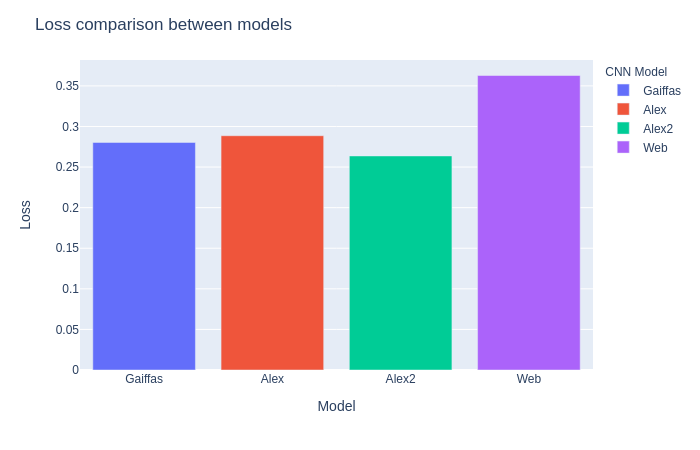

In [309]:
fig = px.bar(testing_accuracy_df, x='model', y='loss', hover_data=['loss', 'model'], 
             color='model', height=600,
             color_continuous_scale=px.colors.sequential.Viridis
            )

fig.update_layout(
    title="Loss comparison between models",
    xaxis_title="Model",
    yaxis_title="Loss",
    legend_title_text='CNN Model'
)

fig.show(renderer="png")

# Predictions

In [275]:
# Get the indices to be plotted
actual_labels = []
for i in range(len(test_labels)):
    result = test_labels[i]
    actual_labels.append(np.argmax(result))

## Model 1: Gaiffas

In [277]:
# Get the predictions for the test data
predicted_classes = gaiffas_model.predict_classes(test_images)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [278]:
p = predicted_classes[:10000]
y = actual_labels[:10000]
correct = np.nonzero(p==y)[0]
incorrect = np.nonzero(p!=y)[0]

In [279]:
print("Correct predicted classes:",correct.shape[0])
print("Incorrect predicted classes:",incorrect.shape[0])

Correct predicted classes: 8989
Incorrect predicted classes: 1011


In [282]:
labels = {0 : "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}
target_names = ["Class {} ({}) :".format(i,labels[i]) for i in range(10)]
print(classification_report(actual_labels, predicted_classes, target_names=target_names))

                         precision    recall  f1-score   support

Class 0 (T-shirt/top) :       0.84      0.88      0.86      1000
    Class 1 (Trouser) :       0.99      0.98      0.98      1000
   Class 2 (Pullover) :       0.81      0.84      0.83      1000
      Class 3 (Dress) :       0.92      0.89      0.90      1000
       Class 4 (Coat) :       0.79      0.85      0.82      1000
     Class 5 (Sandal) :       0.99      0.96      0.97      1000
      Class 6 (Shirt) :       0.76      0.67      0.71      1000
    Class 7 (Sneaker) :       0.94      0.97      0.96      1000
        Class 8 (Bag) :       0.98      0.98      0.98      1000
 Class 9 (Ankle Boot) :       0.96      0.97      0.97      1000

               accuracy                           0.90     10000
              macro avg       0.90      0.90      0.90     10000
           weighted avg       0.90      0.90      0.90     10000



### This shows that Shirts are the most difficult to classify correctly with an  F1-score of 0.74. Pullovers and coats are also quite difficult with both F1-scores being 0.84 

# Which clothes are hard to distinguish?

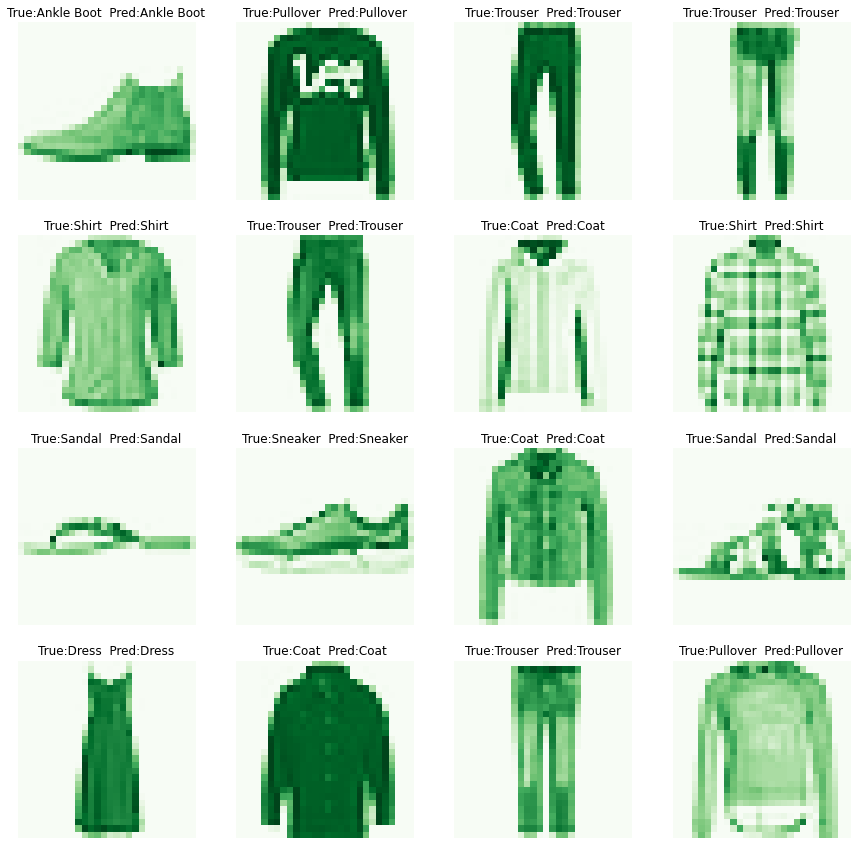

In [283]:
def plot_images(data_index,cmap="Blues"):
    # Plot the sample images now
    f, ax = plt.subplots(4,4, figsize=(15,15))

    for i, indx in enumerate(data_index[:16]):
        ax[i//4, i%4].imshow(test_images[indx].reshape(28,28), cmap=cmap)
        ax[i//4, i%4].axis('off')
        ax[i//4, i%4].set_title("True:{}  Pred:{}".format(labels[actual_labels[indx]],labels[predicted_classes[indx]]))
    plt.show()    
    
plot_images(correct, "Greens")


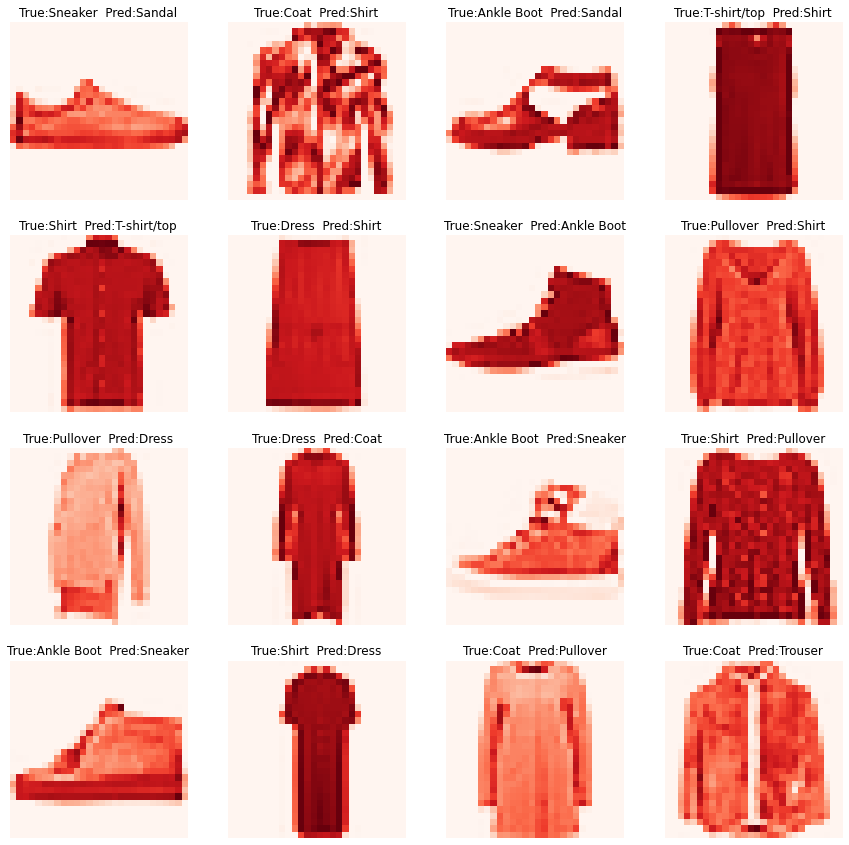

In [284]:
plot_images(incorrect, "Reds")

### It is hard to differentiate between some clothes types such as Shirt vs T-shirt/top since they have similar shape and size. Here we see that even for humans it is quite difficult to correctly identify the fashion item. 

In [298]:
predicted_labels = []
for i in range(len(test_images)):
    img = test_images[i]
    img = img.reshape(1,28,28,1)
    result = gaiffas_model.predict(img)
    predicted_labels.append(np.argmax(result))

In [299]:
incorrect_predictions= []
labels_not_correctly_predicted_by_model = []
i = 0
for i in range(len(predicted_labels)):
    if predicted_labels[i] != actual_labels[i]:
        incorrect_predictions.append(predicted_labels[i])
        labels_not_correctly_predicted_by_model.append(actual_labels[i])
        

# Pairs is just turning the two arrays incco incorrect_predictions and 
# labels_not_correctly_predicted_by_model into one in order to count the occurrences
pairs = np.column_stack((incorrect_predictions, labels_not_correctly_predicted_by_model))
pairs = pairs.tolist()

In [301]:
#Here we find the most common errors
columns = ['Incorrect prediction','Label that was not predicted correctly', 'Error frequency of pair']
df = pd.DataFrame(columns=columns)

for i in range(10):
    for j in range(10):
        df = df.append({'Incorrect prediction': i, 
                        'Label that was not predicted correctly':j,
                        'Error frequency of pair':pairs.count([i,j])}, 
                       ignore_index=True)
        
df = df.sort_values(['Error frequency of pair'], ascending=[False])
df = df.reset_index()
df = df.drop(df.columns[0], axis=1)

df.head()

,Incorrect prediction,Label that was not predicted correctly,Error frequency of pair
0,4,6,489
1,4,2,256
2,4,3,143
3,0,6,139
4,6,0,91


### We can see here that Labels 2 (pullover),4 (coat), 6 (shirt) and 0 (t-shirt/top) are difficult to distinguish from each other. Let us see one instance of each error

In [302]:
# Here we take one example of the five most common errors
example_of_most_common_errors=[]
example_of_most_common_errors.append(next(i for i in range(len(predicted_labels)) if predicted_labels[i]==df.at[0,'Incorrect prediction'] and actual_labels[i]==df.at[0,'Label that was not predicted correctly']))
example_of_most_common_errors.append(next(i for i in range(len(predicted_labels)) if predicted_labels[i]==df.at[1,'Incorrect prediction'] and actual_labels[i]==df.at[1,'Label that was not predicted correctly']))
example_of_most_common_errors.append(next(i for i in range(len(predicted_labels)) if predicted_labels[i]==df.at[2,'Incorrect prediction'] and actual_labels[i]==df.at[2,'Label that was not predicted correctly']))
example_of_most_common_errors.append(next(i for i in range(len(predicted_labels)) if predicted_labels[i]==df.at[3,'Incorrect prediction'] and actual_labels[i]==df.at[3,'Label that was not predicted correctly']))
example_of_most_common_errors.append(next(i for i in range(len(predicted_labels)) if predicted_labels[i]==df.at[4,'Incorrect prediction'] and actual_labels[i]==df.at[4,'Label that was not predicted correctly']))


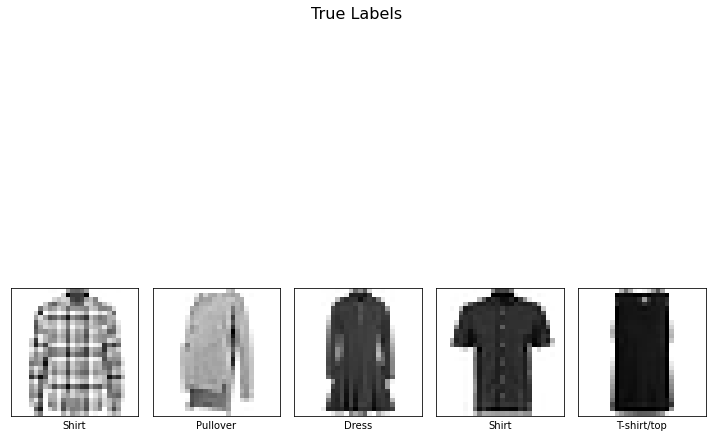

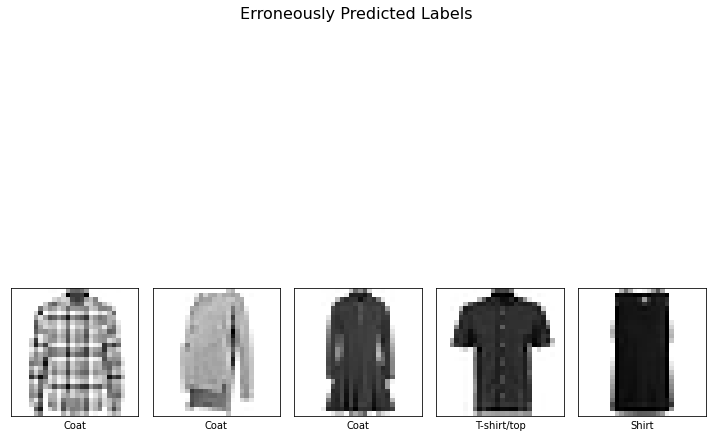

In [307]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
plt.figure(figsize=(10,10))
for i in range(len(example_of_most_common_errors)):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[example_of_most_common_errors[i]], cmap=plt.cm.binary)
    plt.xlabel(class_names[test_labels[example_of_most_common_errors[i]]])
    plt.tight_layout()
plt.suptitle("True Labels", size=16)


plt.figure(figsize=(10,10))
for i in range(len(example_of_most_common_errors)):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[example_of_most_common_errors[i]], cmap=plt.cm.binary)
    plt.xlabel(class_names[predicted_labels[example_of_most_common_errors[i]]])
    plt.tight_layout()
plt.suptitle("Erroneously Predicted Labels", size=16)
plt.show()

Here we can see that the clothing items look quite similar due to them having similar general shapes and pixel intensity. Even a human would probably not differentiate all these clothing items correctly.